In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
import matplotlib.pyplot as plt

In [49]:
# -----------------------------
# 1. Tickers and data download
# -----------------------------
tickers = ["AMZN", "AAPL", "MSFT", "GOOGL", "META"]
all_data = {}

for t in tickers:
    df = yf.download(t, start="2015-01-01", end="2025-01-01")
    all_data[t] = df[['Close']].dropna().reset_index(drop=True)

/tmp/ipython-input-2617836930.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2617836930.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2617836930.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2617836930.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-261783693

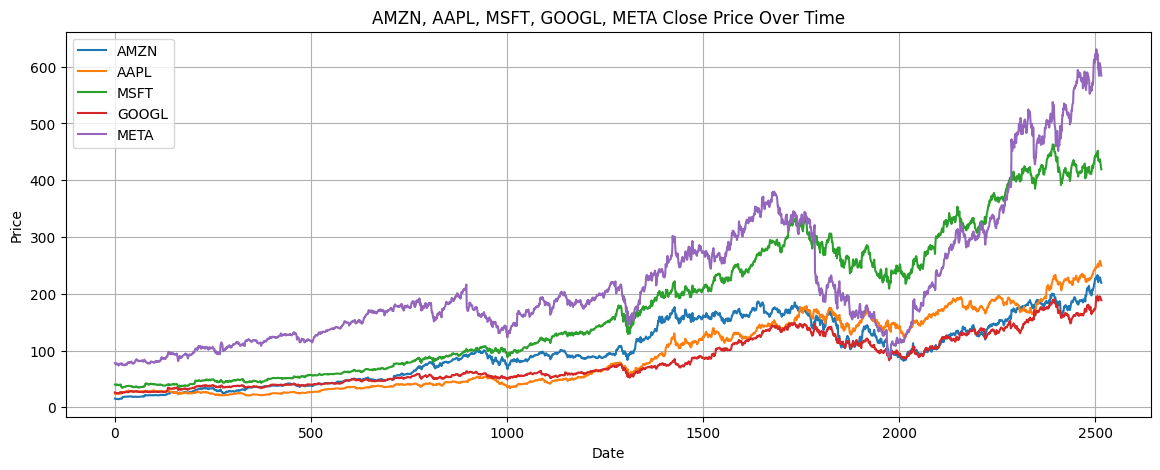

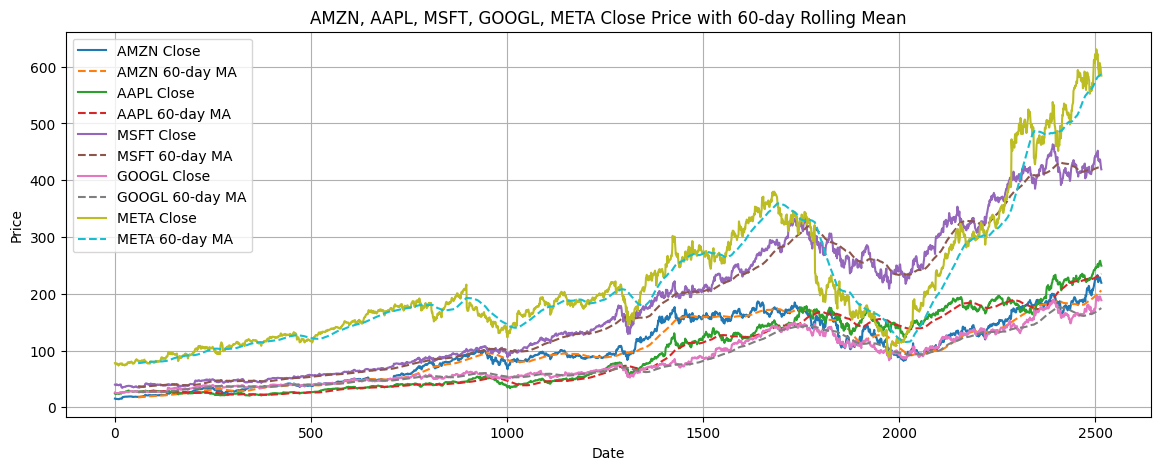

In [50]:
# -----------------------------
# Plot Close Price over time
# -----------------------------
plt.figure(figsize=(14,5))
for ticker in tickers:
    plt.plot(all_data[ticker]['Close'], label=ticker)
plt.title(f"{', '.join(tickers)} Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


# -----------------------------
# Rolling mean for trend
# -----------------------------
plt.figure(figsize=(14,5))
for ticker in tickers:
    rolling = all_data[ticker]['Close'].rolling(window=60).mean()
    plt.plot(all_data[ticker]['Close'], label=f'{ticker} Close')
    plt.plot(rolling, label=f'{ticker} 60-day MA', linestyle='--')
plt.title(f"{', '.join(tickers)} Close Price with 60-day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
scalers = {}
scaler = MinMaxScaler()
for t in tickers:
  all_data[t]['Close_Scaled'] = scaler.fit_transform(all_data[t][['Close']])
  scalers[t] = scaler

In [52]:
# -----------------------------
# 2. Sequence creation
# -----------------------------
seq_length = 30
X_all, y_all = [], []

for t in tickers:
    data_scaled = all_data[t]['Close_Scaled'].values
    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i-seq_length:i].reshape(-1,1))
        y.append(data_scaled[i])
    X_all.extend(X)
    y_all.extend(y)

X_all = np.array(X_all)   # (num_samples, seq_length, 1)
y_all = np.array(y_all)   # (num_samples,)

In [53]:
# -----------------------------
# 3. Train-test split
# -----------------------------
train_size = int(0.8*len(X_all))
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [54]:
# -----------------------------
# 4. Dataset & DataLoader
# -----------------------------
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(StockDataset(X_test, y_test), batch_size=64, shuffle=False)


In [55]:

# -----------------------------
# 5. GRU Model
# -----------------------------
class GRUStock(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(GRUStock, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0)
        self.fc = nn.Linear(hidden_size,1)
    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:,-1,:])
        return out

In [56]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUStock().to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
# -----------------------------
# 6. Training with Early Stopping
# -----------------------------
num_epochs = 100
patience = 10
best_loss = np.inf
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        val_preds = model(X_test.to(device))
        val_loss = criterion(val_preds, y_test.to(device)).item()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_multi_ticker_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

# -----------------------------
# 7. Evaluation per ticker
# -----------------------------
model.load_state_dict(torch.load("best_multi_ticker_model.pth"))
model.eval()

for t in tickers:
    data_scaled = all_data[t]['Close_Scaled'].values
    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i-seq_length:i].reshape(-1,1))
        y.append(data_scaled[i])
    X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y = np.array(y)

    with torch.no_grad():
        y_pred = model(X).cpu().numpy()
    y_inv = scalers[t].inverse_transform(y.reshape(-1,1))
    y_pred_inv = scalers[t].inverse_transform(y_pred)

    rmse = np.sqrt(mean_squared_error(y_inv, y_pred_inv))
    mae = mean_absolute_error(y_inv, y_pred_inv)
    r2 = r2_score(y_inv, y_pred_inv)
    print(f"\n--- {t} Test Metrics ---")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

Epoch 1/100 | Train Loss: 0.004547 | Val Loss: 0.000128
Epoch 2/100 | Train Loss: 0.000203 | Val Loss: 0.000153
Epoch 3/100 | Train Loss: 0.000178 | Val Loss: 0.000118
Epoch 4/100 | Train Loss: 0.000175 | Val Loss: 0.000113
Epoch 5/100 | Train Loss: 0.000155 | Val Loss: 0.000118
Epoch 6/100 | Train Loss: 0.000151 | Val Loss: 0.000146
Epoch 7/100 | Train Loss: 0.000150 | Val Loss: 0.000202
Epoch 8/100 | Train Loss: 0.000149 | Val Loss: 0.000106
Epoch 9/100 | Train Loss: 0.000131 | Val Loss: 0.000104
Epoch 10/100 | Train Loss: 0.000130 | Val Loss: 0.000124
Epoch 11/100 | Train Loss: 0.000131 | Val Loss: 0.000104
Epoch 12/100 | Train Loss: 0.000113 | Val Loss: 0.000086
Epoch 13/100 | Train Loss: 0.000124 | Val Loss: 0.000089
Epoch 14/100 | Train Loss: 0.000103 | Val Loss: 0.000077
Epoch 15/100 | Train Loss: 0.000107 | Val Loss: 0.000082
Epoch 16/100 | Train Loss: 0.000106 | Val Loss: 0.000072
Epoch 17/100 | Train Loss: 0.000095 | Val Loss: 0.000073
Epoch 18/100 | Train Loss: 0.000104 | Va